#FINRL Train Stock Trading
https://github.com/AI4Finance-LLC/FinRL/blob/master/finrl/train.py

In this work SAC used as RL agorithm rather than D Q-Network. The reason of this choice explained in "Train Model" section.

Multi-stock trading data used in train and trade data part. So this work related to multi-stock trading with RL. DOW The latest market data for all 30 stocks in the Dow Jones Industrial Average. So in this work there is "BIST_30_TICKER" relates with that.



#SETUP

In [1]:
 # Install the unstable development version in Jupyter notebook:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-0k1icfx6
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-0k1icfx6
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-mbke4m8j/pyfolio_b16403b9e26e405f9b6fdd904d0629a1
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-mbke4m8j/pyfolio_b16403b9e26e405f9b6fdd904d0629a1


In [2]:
#for data download part -- yahoo finance
!pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

matplotlib.use("Agg")
import datetime

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading_cashpenalty import StockTradingEnvCashpenalty
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import itertools


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [4]:
import pandas as pd
import yfinance as yf

#Collect Data

In [5]:
stockList = ["AKBNK.IS","ARCLK.IS","ASELS.IS","BIMAS.IS","DOHOL.IS","EKGYO.IS","EREGL.IS","FROTO.IS","GARAN.IS","GUBRF.IS","HALKB.IS","ISCTR.IS","KCHOL.IS","KOZAA.IS","KOZAL.IS",
"KRDMD.IS","PETKM.IS","PGSUS.IS","SAHOL.IS","SASA.IS","SISE.IS","TAVHL.IS","TCELL.IS","THYAO.IS","TKFEN.IS","TTKOM.IS","TUPRS.IS","VAKBN.IS","VESTL.IS","YKBNK.IS"]
len(stockList)

30

In [6]:
# print("==============Start Fetching Data===========")
# df = YahooDownloader(
#     start_date=config.START_DATE,
#     end_date=config.END_DATE,
#     ticker_list=stockList,
# ).fetch_data()

In [7]:
tickers = ["VESTL.IS","VAKBN.IS","TUPRS.IS""THYAO.IS","HALKB.IS","SASA.IS","PETKM.IS","SAHOL.IS","PGSUS.IS","GARAN.IS","AKBNK.IS","ARCLK.IS","BIMAS.IS","EREGL.IS"] # 20 tane hisse


In [8]:
date1="2015-07-27"
date2="2021-07-28"
list_data = []
for ticker in tickers:
  data = yf.download(tickers=ticker , start=date1, end=date2, interval='1d' )
  data["tic"] = ticker
  data["date"] = data.index
  data = data.reset_index()
  list_data.append(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TUPRS.ISTHYAO.IS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
list_data

[           Date       Open       High  ...   Volume       tic       date
 0    2015-07-27   4.450000   4.450000  ...  1074220  VESTL.IS 2015-07-27
 1    2015-07-28   4.450000   4.470000  ...  1609540  VESTL.IS 2015-07-28
 2    2015-07-29   4.430000   4.460000  ...   981396  VESTL.IS 2015-07-29
 3    2015-07-30   4.480000   4.490000  ...   871776  VESTL.IS 2015-07-30
 4    2015-07-31   4.480000   4.650000  ...  6003500  VESTL.IS 2015-07-31
 ...         ...        ...        ...  ...      ...       ...        ...
 1526 2021-07-14  30.420000  31.440001  ...  2070274  VESTL.IS 2021-07-14
 1527 2021-07-16  31.420000  31.620001  ...  1660750  VESTL.IS 2021-07-16
 1528 2021-07-19  31.400000  32.160000  ...  1369061  VESTL.IS 2021-07-19
 1529 2021-07-26  32.200001  32.279999  ...  2489134  VESTL.IS 2021-07-26
 1530 2021-07-27  31.980000  32.099998  ...  1726049  VESTL.IS 2021-07-27
 
 [1531 rows x 9 columns],
            Date  Open  High   Low  ...  Adj Close    Volume       tic       date
 0

In [10]:
import pandas as pd
df = pd.concat(list_data)

del df['Date']

In [11]:

df.isna().sum()
multi_ticker_df = df.ffill().bfill()
print(multi_ticker_df)

           Open       High        Low  ...      Volume       tic       date
0      4.450000   4.450000   4.330000  ...   1074220.0  VESTL.IS 2015-07-27
1      4.450000   4.470000   4.370000  ...   1609540.0  VESTL.IS 2015-07-28
2      4.430000   4.460000   4.410000  ...    981396.0  VESTL.IS 2015-07-29
3      4.480000   4.490000   4.430000  ...    871776.0  VESTL.IS 2015-07-30
4      4.480000   4.650000   4.480000  ...   6003500.0  VESTL.IS 2015-07-31
...         ...        ...        ...  ...         ...       ...        ...
1526  17.990000  18.400000  17.990000  ...  19197906.0  EREGL.IS 2021-07-14
1527  18.250000  18.250000  17.910000  ...  17163796.0  EREGL.IS 2021-07-16
1528  18.000000  18.030001  17.850000  ...   5709839.0  EREGL.IS 2021-07-19
1529  18.040001  18.250000  18.000000  ...  23665915.0  EREGL.IS 2021-07-26
1530  18.070000  18.490000  17.969999  ...  25081610.0  EREGL.IS 2021-07-27

[18372 rows x 8 columns]


In [12]:
# print("==============Start Fetching Data===========")
# df_ = YahooDownloader(
#     start_date=config.START_DATE,
#     end_date=config.END_DATE,
#     ticker_list=config.DOW_30_TICKER,
# ).fetch_data()

In [13]:
type(multi_ticker_df)

pandas.core.frame.DataFrame

In [14]:
multi_ticker_df.columns= multi_ticker_df.columns.str.strip().str.lower()
multi_ticker_df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'tic', 'date'], dtype='object')

In [15]:
def prefill(multi_ticker_df)  :
    df = multi_ticker_df.copy()
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]
    merged_closes = df.pivot_table(index = 'date',columns = 'tic', values = 'close')

    print(merged_closes.isna().sum())
    merged_closes = merged_closes.ffill().bfill()

    # print(merged_closes.isna().sum())
    # print(merged_closes)
    tics = merged_closes.columns
    df = df[df.tic.isin(tics)]
    df = df.reset_index()
    del df['index']
    return df
multiticker_df = prefill(multi_ticker_df)


tic
AKBNK.IS    0
ARCLK.IS    0
BIMAS.IS    0
EREGL.IS    0
GARAN.IS    0
HALKB.IS    0
PETKM.IS    0
PGSUS.IS    0
SAHOL.IS    0
SASA.IS     0
VAKBN.IS    0
VESTL.IS    0
dtype: int64


In [16]:
print(multiticker_df)

            open       high        low  ...      volume       tic       date
0       6.182181   6.182181   6.122160  ...  13466375.0  AKBNK.IS 2015-07-27
1      14.750000  14.950000  14.500000  ...   1976842.0  ARCLK.IS 2015-07-27
2      23.525000  23.799999  23.325001  ...    628882.0  BIMAS.IS 2015-07-27
3       3.990000   4.040000   3.960000  ...   6776403.0  EREGL.IS 2015-07-27
4       7.900000   7.910000   7.740000  ...  63095366.0  GARAN.IS 2015-07-27
...          ...        ...        ...  ...         ...       ...        ...
18367  67.699997  71.949997  67.199997  ...   3505926.0  PGSUS.IS 2021-07-27
18368   9.070000   9.300000   9.020000  ...  17634418.0  SAHOL.IS 2021-07-27
18369  29.680000  30.299999  29.340000  ...  15605997.0   SASA.IS 2021-07-27
18370   3.430000   3.440000   3.390000  ...  30871452.0  VAKBN.IS 2021-07-27
18371  31.980000  32.099998  31.740000  ...   1726049.0  VESTL.IS 2021-07-27

[18372 rows x 8 columns]


#Feature Engineering

In [17]:
print("==============Start Feature Engineering===========")
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=tech_indicator_list,
    use_turbulence=True,
    user_defined_feature=False,
)

==============Start Feature Engineering===========


In [18]:
tech_indicator_list

['macd', 'rsi_30', 'cci_30', 'dx_30']

In [19]:
processed = fe.preprocess_data(multiticker_df)


Successfully added technical indicators
Successfully added turbulence index


In [20]:
processed

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375.0,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
1,14.750000,14.950000,14.500000,14.600000,11.878804,1976842.0,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
2,23.525000,23.799999,23.325001,23.600000,19.072001,628882.0,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
3,3.990000,4.040000,3.960000,4.040000,1.965522,6776403.0,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
4,7.900000,7.910000,7.740000,7.760000,6.942376,63095366.0,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
18368,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
18369,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
18370,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


In [21]:
processed_full = processed.sort_values(['date','tic'])
processed_full= processed_full.ffill().bfill()

In [22]:
processed_full

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375.0,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
1,14.750000,14.950000,14.500000,14.600000,11.878804,1976842.0,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
2,23.525000,23.799999,23.325001,23.600000,19.072001,628882.0,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
3,3.990000,4.040000,3.960000,4.040000,1.965522,6776403.0,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
4,7.900000,7.910000,7.740000,7.760000,6.942376,63095366.0,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
18368,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
18369,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
18370,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


# Training & Trading data split

In [23]:
date1="2015-07-27"
date2="2021-07-28"
date3= "2020-07-27"

In [24]:
train = data_split(processed_full,date1, date3)
trade = data_split(processed_full, date3, date2)


# Calculate state action space


In [25]:
stock_dimension = len(train.tic.unique()) # number of tickers
state_space = (
        1
        + 2 * stock_dimension
        + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension)

In [26]:
stock_dimension ,state_space

(12, 73)

# ENV CREATE

In [27]:
env_kwargs = {
        "hmax": 100, 
        "initial_amount": 1000000, 
        "buy_cost_pct": 0.001, 
        "sell_cost_pct": 0.001
}

In [28]:
e_train_gym = StockTradingEnvCashpenalty(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

caching data
data cached!


In [29]:
env_train

In [30]:
_

#SET AGENT

In [31]:
agent = DRLAgent(env=env_train)


#Model Training
We use Soft Actor-Critic (SAC) for multiple stock trading, because it is one of the most recent state-of-art algorithms. SAC is featured by its stability.

For more info about SAC :https://bit.ly/3yuKz8a

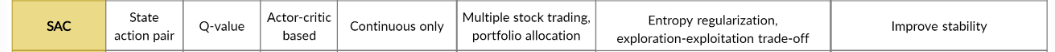

In [32]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_sac = agent.get_model("sac")
trained_sac = agent.train_model(model=model_sac, tb_log_name="sac", total_timesteps=10000 )

==============Model Training===========
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to tensorboard_log/sac/sac_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   9|update         |$999,349       |$1,000,005     |0.00006%  |0.00046%  |99.93%    
   1|  19|update         |$997,521       |$1,000,032     |0.00018%  |0.00320%  |99.75%    
   1|  29|update         |$997,357       |$1,000,175     |0.00062%  |0.01747%  |99.72%    
   1|  39|update         |$997,040       |$1,000,320     |0.00084%  |0.03201%  |99.67%    
   1|  49|update         |$996,653       |$1,000,106     |0.00022%  |0.01060%  |99.65%    
   1|  59|update         |$995,621       |$999,946       |-0.00009% |-0.00542% |99.57%    
   1|  69|update         |$995,232       |$1,000,178     |0.00026%  |0.01783%  |99.51%    
   1|  79|update         |$994,862       

#Save Model

In [33]:
!mkdir -p saved_model
trained_sac.save('saved_model/my_modelBIST.h5') 

In [34]:
trained_sac

In [35]:
print("==============Start Trading===========")
e_trade_gym = StockTradingEnvCashpenalty(df=trade, turbulence_threshold=250, **env_kwargs)

df_account_value, df_actions = DRLAgent.DRL_prediction( model=trained_sac, environment = e_trade_gym)


==============Start Trading===========
caching data
data cached!
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   9|update         |$997,598       |$999,934       |-0.00082% |-0.00659% |99.77%    
   1|  19|update         |$994,597       |$999,710       |-0.00161% |-0.02899% |99.49%    
   1|  29|update         |$991,493       |$999,803       |-0.00071% |-0.01975% |99.17%    
   1|  39|update         |$988,770       |$999,332       |-0.00176% |-0.06678% |98.94%    
   1|  49|update         |$986,175       |$999,344       |-0.00137% |-0.06559% |98.68%    
   1|  59|update         |$983,065       |$997,521       |-0.00427% |-0.24792% |98.55%    
   1|  69|update         |$979,761       |$997,082       |-0.00429% |-0.29184% |98.26%    
   1|  79|update         |$977,052       |$996,947       |-0.00391% |-0.30527% |98.00%    
   1|  89|update         |$974,847       |$997,415       |-0.00294% |-0.25851% |97.74%    
   1

In [38]:
df_actions

,date,actions,transactions
0,2021-01-07,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.60544235340355, -0.0, 1.3089004974185385, ..."
1,2021-01-08,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.280212113373256, -0.0, 1.2987012987012987,..."
2,2021-01-11,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.297872374153828, -0.0, 1.3114754098360655,..."
3,2021-01-12,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.67989066795754, -0.0, 1.3080445257270779, ..."
4,2021-01-13,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.736263340386985, -0.0, 1.3140604731287406,..."
...,...,...,...
130,2021-07-14,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[19.08397029923171, -0.0, 1.6339869077347535, ..."
131,2021-07-16,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[18.903591818736256, -0.0, 1.6207455229087406,..."
132,2021-07-19,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[19.08397029923171, -0.0, 1.6194331983805668, ..."
133,2021-07-26,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[19.379845534327472, -0.0, 1.636661252002404, ..."


In [37]:
df_account_value

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2021-01-07
1,999699.700000,304.102373,1.000004e+06,0.000004,2021-01-08
2,999399.400000,603.260720,1.000003e+06,0.000001,2021-01-11
3,999099.100000,895.605981,9.999947e+05,-0.000002,2021-01-12
4,998798.800000,1192.160608,9.999910e+05,-0.000002,2021-01-13
...,...,...,...,...,...
130,962758.966468,34346.982705,9.971059e+05,-0.000022,2021-07-14
131,962458.666468,34982.240193,9.974409e+05,-0.000020,2021-07-16
132,962158.366468,35204.370170,9.973627e+05,-0.000020,2021-07-19
133,961858.066468,35197.930638,9.970560e+05,-0.000022,2021-07-26


In [39]:
df_account_value

profit_list = []
ac_val = list(df_account_value["total_assets"])
print(ac_val)
turn =len(ac_val)
for i in range(turn):
  
  if i != turn-1:

    diff = ac_val[i+1]  - ac_val[i]
    profit_list.append(diff)
  else:
    profit_list.append(float(0))
    
print(profit_list)


[1000000.0, 1000003.8023726308, 1000002.6607198486, 999994.7059811602, 999990.9606083877, 999989.7364510243, 999968.4098058039, 999915.3922272916, 999934.062913545, 999924.149497139, 999936.1874143954, 999904.0908152892, 999853.3942995734, 999813.0564015725, 999868.2230114699, 999744.5755868616, 999767.9582911574, 999659.1967572772, 999710.1488231074, 999747.8655027859, 999870.5795104007, 999836.8373565661, 999800.7865197656, 999805.2458914807, 999871.4273507701, 999918.5255585111, 999853.1024370199, 999740.9463236427, 999802.513186716, 999623.8743012699, 999578.7900750656, 999506.7143706915, 999600.5021539244, 999518.9888431712, 999434.9167621623, 999243.370652002, 999273.5400994857, 999082.0045699695, 999332.21275685, 999384.1089416326, 999249.1705662846, 999331.1720085305, 999486.0873883697, 999243.2604455226, 999402.6195923096, 999462.4084538118, 999406.3095590161, 999446.9276643296, 999344.0609741089, 999434.3898696168, 999223.2707513522, 999394.9170103177, 999091.0192926507, 9976

In [40]:
new_df = df_account_value.copy()

new_df["diff"] = np.array(profit_list)

new_df

,cash,asset_value,total_assets,reward,date,diff
0,1000000.000000,0.000000,1.000000e+06,0.000000,2021-01-07,3.802373
1,999699.700000,304.102373,1.000004e+06,0.000004,2021-01-08,-1.141653
2,999399.400000,603.260720,1.000003e+06,0.000001,2021-01-11,-7.954739
3,999099.100000,895.605981,9.999947e+05,-0.000002,2021-01-12,-3.745373
4,998798.800000,1192.160608,9.999910e+05,-0.000002,2021-01-13,-1.224157
...,...,...,...,...,...,...
130,962758.966468,34346.982705,9.971059e+05,-0.000022,2021-07-14,334.957488
131,962458.666468,34982.240193,9.974409e+05,-0.000020,2021-07-16,-78.170022
132,962158.366468,35204.370170,9.973627e+05,-0.000020,2021-07-19,-306.739532
133,961858.066468,35197.930638,9.970560e+05,-0.000022,2021-07-26,129.991614


In [41]:
%matplotlib inline

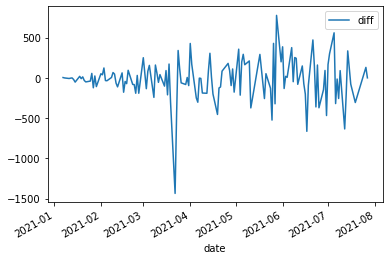

In [42]:
# hesaptaki günlük kar-zarar grafiği
new_df.plot(x='date', y='diff', kind = 'line')

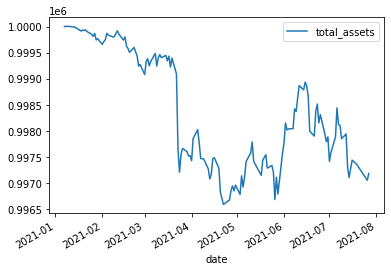

In [43]:
# total hesaptaki maliyetin değişimi
new_df.plot(x='date', y='total_assets', kind = 'line')

In [44]:
df_actions

,date,actions,transactions
0,2021-01-07,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.60544235340355, -0.0, 1.3089004974185385, ..."
1,2021-01-08,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.280212113373256, -0.0, 1.2987012987012987,..."
2,2021-01-11,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.297872374153828, -0.0, 1.3114754098360655,..."
3,2021-01-12,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.67989066795754, -0.0, 1.3080445257270779, ..."
4,2021-01-13,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.736263340386985, -0.0, 1.3140604731287406,..."
...,...,...,...
130,2021-07-14,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[19.08397029923171, -0.0, 1.6339869077347535, ..."
131,2021-07-16,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[18.903591818736256, -0.0, 1.6207455229087406,..."
132,2021-07-19,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[19.08397029923171, -0.0, 1.6194331983805668, ..."
133,2021-07-26,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[19.379845534327472, -0.0, 1.636661252002404, ..."


In [45]:
import os
cwd = os.getcwd()
cwd

'/content'

In [46]:
import os
os.chdir('/content/saved_model')


with open("./" + "/df_account_value_BIST" + now + ".csv", 'a') as f1:
    df_account_value.to_csv(f1, header=False)

with open("./"+ "/df_actions_BIST" + now + ".csv", 'a') as f2:
    df_actions.to_csv(f2, header=False)




#Backtesting 

In [48]:
# print("==============Get Backtest Results===========")
# perf_stats_all = backtest_stats(df_account_value)
# perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./" +"/perf_stats_all_BIST" + now + ".csv")


 #Understanding Format of Variables:

In [49]:
train

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375.0,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,14.750000,14.950000,14.500000,14.600000,11.878804,1976842.0,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,23.525000,23.799999,23.325001,23.600000,19.072001,628882.0,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,3.990000,4.040000,3.960000,4.040000,1.965522,6776403.0,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,7.900000,7.910000,7.740000,7.760000,6.942376,63095366.0,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,51.000000,51.900002,50.650002,51.349998,51.349998,2002048.0,PGSUS.IS,2020-07-24,-1.015999,46.712444,-87.886699,5.067109,2.554014
1281,9.150000,9.150000,9.050000,9.100000,8.755303,5455417.0,SAHOL.IS,2020-07-24,0.065249,52.595700,-79.706951,3.445070,2.554014
1281,10.004468,10.263843,9.930361,10.123040,10.123040,29892348.0,SASA.IS,2020-07-24,0.633239,68.646562,138.956885,47.425085,2.554014
1281,4.890000,4.920000,4.840000,4.880000,4.880000,39839221.0,VAKBN.IS,2020-07-24,-0.010792,48.479858,-67.830976,7.872245,2.554014


In [50]:
trade

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,5.800000,5.810000,5.700000,5.720000,5.578002,43319180.0,AKBNK.IS,2020-07-27,-0.032535,45.321645,-107.064136,3.281478,6.141735
0,22.240000,22.540001,22.100000,22.160000,20.744827,10243494.0,ARCLK.IS,2020-07-27,1.084334,71.838800,145.124012,62.664200,6.141735
0,74.699997,75.900002,74.250000,74.300003,69.351898,2675233.0,BIMAS.IS,2020-07-27,1.951131,65.861834,192.733720,48.082447,6.141735
0,8.410000,8.510000,8.390000,8.470000,7.452500,36658368.0,EREGL.IS,2020-07-27,0.000343,50.769015,-40.977438,1.932329,6.141735
0,7.950000,7.960000,7.770000,7.800000,7.635209,98366875.0,GARAN.IS,2020-07-27,-0.083367,43.797485,-114.132586,16.189562,6.141735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
248,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
248,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
248,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


In [51]:
e_train_gym

In [52]:
agent

In [53]:
model_sac

In [55]:
trained_sac

In [54]:
e_trade_gym

In [56]:
df_account_value

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2021-01-07
1,999699.700000,304.102373,1.000004e+06,0.000004,2021-01-08
2,999399.400000,603.260720,1.000003e+06,0.000001,2021-01-11
3,999099.100000,895.605981,9.999947e+05,-0.000002,2021-01-12
4,998798.800000,1192.160608,9.999910e+05,-0.000002,2021-01-13
...,...,...,...,...,...
130,962758.966468,34346.982705,9.971059e+05,-0.000022,2021-07-14
131,962458.666468,34982.240193,9.974409e+05,-0.000020,2021-07-16
132,962158.366468,35204.370170,9.973627e+05,-0.000020,2021-07-19
133,961858.066468,35197.930638,9.970560e+05,-0.000022,2021-07-26


In [57]:
df_actions

,date,actions,transactions
0,2021-01-07,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.60544235340355, -0.0, 1.3089004974185385, ..."
1,2021-01-08,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.280212113373256, -0.0, 1.2987012987012987,..."
2,2021-01-11,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.297872374153828, -0.0, 1.3114754098360655,..."
3,2021-01-12,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.67989066795754, -0.0, 1.3080445257270779, ..."
4,2021-01-13,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[13.736263340386985, -0.0, 1.3140604731287406,..."
...,...,...,...
130,2021-07-14,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[19.08397029923171, -0.0, 1.6339869077347535, ..."
131,2021-07-16,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[18.903591818736256, -0.0, 1.6207455229087406,..."
132,2021-07-19,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[19.08397029923171, -0.0, 1.6194331983805668, ..."
133,2021-07-26,"[1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...","[19.379845534327472, -0.0, 1.636661252002404, ..."
